In [1]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, auc, roc_auc_score, f1_score, confusion_matrix

import scipy
from scipy.sparse import hstack

# This module will be for saving the trained model for later use
import joblib

import spacy
import re

## Prep training data

In [2]:
import spacy
import re

nlp = spacy.load('en_core_web_sm')

regex1 = re.compile(r'(http\S+)|(#(\w+))|(@(\w+))|[^\w\s]|(\w*\d\w*)')
regex2 = re.compile(r'(\s+)|(\n+)')

def lemmatize(article):
    article = re.sub(regex1, '', article)
    article = re.sub(regex2,' ', article).strip().lower()
    
    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

In [3]:
am = pd.read_csv('../adverse_media_training.csv.zip')
nam = pd.read_csv('../non_adverse_media_training.csv.zip')

am_confirmed = am.loc[(am.label == 'am') | (am.label == 'am ')]
am_confirmed = pd.concat([am_confirmed, nam.loc[nam.label == 'am']])

nam_confirmed = nam.loc[(nam.label == 'nam') | (nam.label == 'random')]
nam_confirmed = pd.concat([nam_confirmed, am.loc[(am.label == 'nam') | (am.label == 'random')]])

am_confirmed['is_adverse_media'] = 1
nam_confirmed['is_adverse_media'] = 0

# Creating the train dataset
data = pd.concat([am_confirmed, nam_confirmed])

data["article"] = data["title"] + " " + data["article"]
data["lemmatized"] = data["article"].apply(lemmatize)

data = data.sample(frac = 1, random_state=42)
data = data.reset_index()
data = data.drop(['index'], axis=1)

In [4]:
x_train = data["lemmatized"]
y_train = data["is_adverse_media"]

### Energize! ...khm, Vectorize.

In [5]:
ngram_vectorizer = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 3))

ngram_vectorizer.fit(x_train)
tfidf_train = ngram_vectorizer.transform(x_train)


### Train all dem modelz!

In [6]:
logit_model = LogisticRegression(solver='sag')
logit_model.fit(tfidf_train, y_train)


LogisticRegression(solver='sag')

In [7]:
nb_model = MultinomialNB(alpha=0.3)
nb_model.fit(tfidf_train, y_train)

MultinomialNB(alpha=0.3)

### Load and prepare public test data

In [8]:
public_test = pd.read_csv('../public_test.csv')
public_test_lemmatized = public_test[['article', 'label']].copy()
public_test_lemmatized["article"] = public_test_lemmatized["article"].apply(lemmatize)
public_test_lemmatized = public_test_lemmatized.reset_index()
public_test_lemmatized = public_test_lemmatized.drop(['index'], axis=1)

tfidf_public_test = ngram_vectorizer.transform(public_test_lemmatized.article)

### Score!

In [9]:
def test_score(model, name, tfidf, labels):
    preds = model.predict(tfidf)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    print(f'Prediction accuracy for {name} model on public test data:', round(accuracy*100, 3))
    print(f'F1 score for {name} model on public test data:', round(f1*100, 3))
    print()

test_score(logit_model, 'logistic regression', tfidf_public_test, public_test.label)
test_score(nb_model, 'naive bayes', tfidf_public_test, public_test.label)


Prediction accuracy for logistic regression model on public test data: 87.421
F1 score for logistic regression model on public test data: 90.291

Prediction accuracy for naive bayes model on public test data: 92.453
F1 score for naive bayes model on public test data: 93.878



logistic regression AUC: 0.9761
naive bayes AUC: 0.9790
BERT AUC: 0.9764


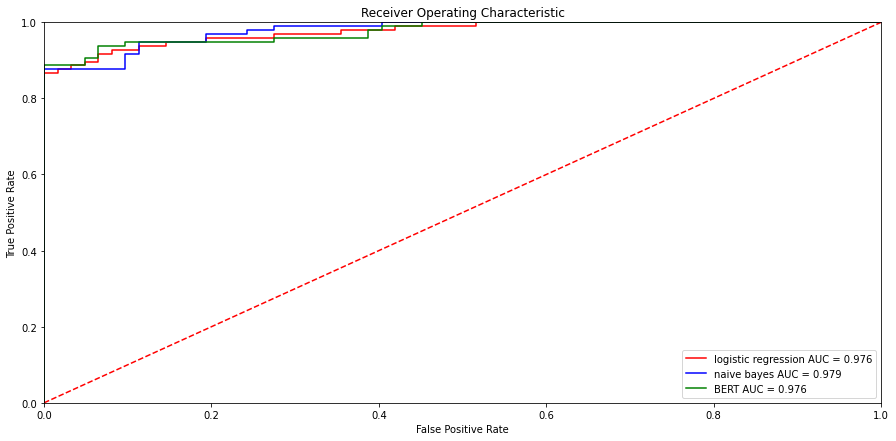

In [10]:
# ROC AUC for Logit, Naive Bayes and BERT on public test data


nb_probs = nb_model.predict_proba(tfidf_public_test)
logit_probs = logit_model.predict_proba(tfidf_public_test)
bert_probs = pd.read_csv('BERT_public_test_preds.csv').prob1.to_numpy()

from sklearn.metrics import accuracy_score, auc, roc_curve
import numpy as np 

def evaluate_roc(model_probs, y_true):
    """
    - Print AUC 
    - Plot ROC
    """

    # Plot ROC AUC
    plt.figure(figsize=(15,7))
    plt.title('Receiver Operating Characteristic')
    colors = {'b', 'r', 'g'}
    for name, preds in model_probs.items():
        fpr, tpr, threshold = roc_curve(y_true, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, colors.pop(), label = f'{name} AUC = %0.3f' % roc_auc)
        print(f'{name} AUC: {roc_auc:.4f}')
        
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

evaluate_roc({'logistic regression': logit_probs[:,1], 'naive bayes': nb_probs[:,1], 'BERT': bert_probs}, public_test.label.to_numpy(), )

In [11]:
pd.DataFrame(nb_probs, columns['prob0'])

array([[1.85542615e-01, 8.14457385e-01],
       [1.10499050e-03, 9.98895010e-01],
       [5.93069674e-02, 9.40693033e-01],
       [1.68163737e-02, 9.83183626e-01],
       [9.66156145e-02, 9.03384385e-01],
       [2.13284006e-02, 9.78671599e-01],
       [1.28107158e-01, 8.71892842e-01],
       [2.19324205e-01, 7.80675795e-01],
       [5.64481933e-02, 9.43551807e-01],
       [2.22349179e-01, 7.77650821e-01],
       [3.30964910e-01, 6.69035090e-01],
       [1.14197137e-01, 8.85802863e-01],
       [7.90133958e-01, 2.09866042e-01],
       [2.65851077e-02, 9.73414892e-01],
       [1.68558095e-03, 9.98314419e-01],
       [4.08211255e-01, 5.91788745e-01],
       [2.20111119e-02, 9.77988888e-01],
       [7.06284768e-03, 9.92937152e-01],
       [4.57306172e-04, 9.99542694e-01],
       [5.99742852e-03, 9.94002571e-01],
       [2.12838509e-03, 9.97871615e-01],
       [1.67554830e-01, 8.32445170e-01],
       [5.74512122e-02, 9.42548788e-01],
       [7.79465043e-03, 9.92205350e-01],
       [1.713209